#### Single Trial Analysis 
##### New Bonsai NWBs

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import codeocean
from codeocean import CodeOcean 
import sys 
import pandas as pd
import os
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from datetime import datetime
from pathlib import Path 
from typing import Union, List, Optional

from IPython.display import display, HTML


import joblib
from joblib import Memory
import re
import glob

from aind_dynamic_foraging_data_utils import nwb_utils as nu
import aind_dynamic_foraging_basic_analysis.licks.annotation as a

sys.path.insert(1, '/root/capsule/code/utils')
import behavior_utils as bu
import array_utils as au
import data_utils as du 
import nwb_utils

In [3]:
data_folder = '/root/capsule/data/'
behavior_folder = '/root/capsule/data/foraging_nwb_bonsai'
master_df_path = '/root/capsule/data/df_processed_20241025.csv'

In [4]:
# No processed_CO_dataID, session_names

master_df = pd.read_csv(master_df_path)
filtered_df = du.filter_fiber_probes(master_df)
data_asset_IDs = du.get_processed_CO_dataID_for_stage(filtered_df, stage = 'STAGE_3')
session_names = du.get_processed_session_name_for_stage(filtered_df, stage = 'STAGE_3')
nwb_suffixes = du.get_nwb_suffix_for_stage(filtered_df, stage = 'STAGE_3')
formatted_suffixes = du.format_nwb_suffixes(nwb_suffixes)

In [ ]:
data_assets = du.generate_data_asset_params(data_asset_IDs, mount_point=None)
token = os.getenv('CUSTOM_KEY')
client = CodeOcean(domain="https://codeocean.allenneuraldynamics.org", token=token)
capsule_id = "6a9f6065-d87a-40ce-831d-0676a2a4a835"
results = client.capsules.attach_data_assets(
    capsule_id=capsule_id,
    attach_params=data_assets,
)

In [5]:
nwb_fib = nu.load_nwb_from_filename(data_folder + 
'behavior_700708_2024-06-20_09-14-58_processed_2024-06-28_23-35-30/nwb/behavior_700708_2024-06-20_09-14-58.nwb')

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [ ]:
nwb_fib

,start_time,stop_time,animal_response,rewarded_historyL,rewarded_historyR,delay_start_time,goCue_start_time,reward_outcome_time,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,reward_random_number_right,left_valve_open_time,right_valve_open_time,block_beta,block_min,block_max,min_reward_each_block,delay_beta,delay_min,delay_max,delay_duration,ITI_beta,ITI_min,ITI_max,ITI_duration,response_duration,reward_consumption_duration,auto_waterL,auto_waterR,laser_on_trial,laser_wavelength,laser_location,laser_power,laser_duration,laser_condition,laser_condition_probability,laser_start,laser_start_offset,laser_end,laser_end_offset,laser_protocol,laser_frequency,laser_rampingdown,laser_pulse_duration,auto_train_engaged,auto_train_curriculum_name,auto_train_curriculum_version,auto_train_curriculum_schema_version,auto_train_stage,auto_train_stage_overridden,lickspout_position_x,lickspout_position_y,lickspout_position_z,reward_size_left,reward_size_right
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.397235e+07,1.397235e+07,1.0,False,True,1.397235e+07,1.397235e+07,1.397235e+07,False,True,0.8,0.0,0.8,0.010383,0.511088,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,3.447869,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
1,1.397235e+07,1.397236e+07,0.0,False,False,1.397236e+07,1.397236e+07,1.397236e+07,False,False,0.8,0.0,0.8,0.652389,0.961181,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,2.244803,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.0,3097.0,2.0,2.0
2,1.397236e+07,1.397237e+07,0.0,False,False,1.397236e+07,1.397236e+07,1.397237e+07,False,False,0.8,0.0,0.8,0.349353,0.896613,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,3.255656,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
3,1.397237e+07,1.397238e+07,0.0,False,False,1.397237e+07,1.397237e+07,1.397238e+07,False,True,0.8,0.0,0.8,0.143479,0.239877,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,5.630439,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
,start_time,stop_time,animal_response,rewarded_historyL,rewarded_historyR,delay_start_time,goCue_start_time,reward_outcome_time,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,reward_random_number_right,left_valve_open_time,right_valve_open_time,block_beta,block_min,block_max,min_reward_each_block,delay_beta,delay_min,delay_max,delay_duration,ITI_beta,ITI_min,ITI_max,ITI_duration,response_duration,reward_consumption_duration,auto_waterL,auto_waterR,laser_on_trial,laser_wavelength,laser_location,laser_power,laser_duration,laser_condition,laser_condition_probability,laser_start,laser_start_offset,laser_end,laser_end_offset,laser_protocol,laser_frequency,laser_rampingdown,laser_pulse_duration,auto_train_engaged,auto_train_curriculum_name,auto_train_curriculum_version,auto_train_curriculum_schema_version,auto_train_stage,auto_train_stage_overridden,lickspout_position_x,lickspout_position_y,lickspout_position_z,reward_size_left,reward_size_right
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.397235e+07,1.397235e+07,1.0,False,True,1.397235e+07,1.397235e+07,1.397235e+07,False,True,0.8,0.0,0.8,0.010383,0.511088,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,3.447869,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
1,1.397235e+07,1.397236e+07,0.0,False,False,1.397236e+07,1.397236e+07,1.397236e+07,False,False,0.8,0.0,0.8,0.652389,0.961181,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,2.244803,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.0,3097.0,2.0,2.0
2,1.397

In [ ]:
fib_df = nwb_utils.create_fib_df(nwb_fib)
fib_df

,timestamps,data,event
0,-721.676768,1.000000,FIP_rising_time
1,-721.661408,1.000000,FIP_falling_time
2,-721.626752,1.000000,FIP_rising_time
3,-721.611392,1.000000,FIP_falling_time
4,-721.576768,1.000000,FIP_rising_time
...,...,...,...
697859,4349.438400,520.621762,Iso_1
697860,4349.537216,326.057013,Iso_2
697861,4349.537216,522.694301,Iso_1
697862,4349.539616,326.348917,Iso_2


##### behavior level analysis

In [6]:
cachedir = '/root/capsule/scratch'
memory = Memory(cachedir, verbose=0)

@memory.cache
def load_nwb_files(base_dir: str, process_data: bool = True, cachedir: str = '/root/capsule/scratch/') -> Union[dict, List]:
    """ 
    Load NWB files from base directory from prior loading in OC capsule (behavior_** subdirecories)

    Params: 
    base_dir (str): Base directory containing behavior sub folders and NWBs 
    ignore_dirs (List[str]) (optional: directories to ignore)
    process_data (bool) (optional: True -> create lick, trial, events DataFrames for each NWB 
    cachedir (str): Cache directory to store CSV files 

    Returns: 
    Union[dict, List]: True -> Dictionary with NWB objects as values and paths as keys 
                       False -> List of paths to NWB files

    """ 

    # Convert to path object
    base_path = Path(base_dir)
    cache_path = Path(cachedir)

    cache_path.mkdir(parents=True, exist_ok = True)

    # Find all directories with regex behavior_** 
    behavior_dirs = list(base_path.glob('behavior_*'))

    if not behavior_dirs:
        raise ValueError(f'No behavior files found in {base_dir}')

    # Find all NWB files in subdirectories 
    nwb_files = []
    for behavior_dir in behavior_dirs:
        nwb_path = behavior_dir / 'nwb'
        if nwb_path.exists():
            nwb_files.extend(list(nwb_path.glob('*.nwb')))

    if not nwb_files:
        raise ValueError(f'No .nwb files found in behavior folders')

    if not process_data:
        return [str(path) for path in nwb_files]

    # Load / process each NWB file
    processed_nwbs = {}
    for nwb_file in nwb_files:
        try:
            # Load NWB file 
            nwb = nu.load_nwb_from_filename(str(nwb_file))

            # Process DataFrames
            nwb.df_trials = nu.create_df_trials(nwb)

            # Extract filenames
            filename = nwb_file.name
            match = re.search(r'behavior_(\d+)_(\d{4}-\d{2}-\d{2})', filename)

            if match:
                subject_id, session_date = match.groups()

                # Save trials to CSVs
                csv_filename = f'{subject_id}_{session_date}_fip_trials.csv'
                csv_path = cache_path / csv_filename
                nwb.df_trials.to_csv(csv_path, index=False)

            processed_nwbs[str(csv_filename)] = nwb.df_trials

        except Exception as e:
            print(f'Error processing {nwb_file}: {str(e)}')
            continue

    return processed_nwbs


In [7]:
base_dir = '/root/capsule/data'
#ignore_dirs = ['filtered_data_session', 'foraging_nwb_bonsai', 'foraging_nwb_bonsai_processed', 'df_processed_20241025.csv']
nwbs = load_nwb_files(base_dir)

In [8]:
nwb1 = nwbs[list(nwbs.keys())[0]]

In [9]:
# Group dictionary by subject_ids, session_dates
subject_dfs = {}

for filename, data, in nwbs.items():
    parts = filename.split('_')
    subject_id = parts[0]
    session_date = parts[1]

    session_date = datetime.strptime(session_date, '%Y-%m-%d')

    data['session_date'] = session_date

    if subject_id not in subject_dfs:
        subject_dfs[subject_id] = []

    subject_dfs[subject_id].append(data)

# Concatenate unique subject_ids together, sort by date 
for subject_id in subject_dfs:
    subject_data = pd.concat(subject_dfs[subject_id], ignore_index=True)

    subject_data = subject_data.sort_values(by='session_date')

    subject_data = subject_data.reset_index(drop=True)

    subject_dfs[subject_id] = subject_data

In [10]:
# Probability chosen metric calculation 

def calculate_probabilities(row):
    # No response results in a NaN value
    if row.animal_response == 2:
        return np.nan, np.nan
    # Chosen = left choice left probability, not chosen = left choice right probability 
    elif row.animal_response == 0:
        return row.reward_probabilityL, row.reward_probabilityR
    else: # Chosen = right choice right probability, not chosen = right choice left probability 
        return row.reward_probabilityR, row.reward_probabilityL


In [11]:
def chosen_metric(df):
    # Calculate the difference for each row
    average = (df['probability_chosen'] - df['probability_not_chosen'])
    
    # Find global maximum
    p_larger_global = max(df['probability_chosen'].max(), df['probability_not_chosen'].max())
    
    # Find global minimum
    p_smaller_global = min(df['probability_chosen'].min(), df['probability_not_chosen'].min())
    
    # Calculate mean of the differences
    mean_difference = average.mean()
    
    # Calculate final metric
    final_metric = mean_difference / (p_larger_global - p_smaller_global)
   
    return(final_metric)

In [12]:
def process_subject_data(subject_dfs):
    """ 
    Process subject DataFrames to calculate probabilities and chosen metrics for each session / subject_id

    Params:
    subject_dfs (dict): Dictionary containing subject_id DataFrames

    Returns:
    processed_dfs (dict): Dictionary containing subject_id DataFrames with probability and chosen metrics
    """ 

    processed_dfs = {}

    for subject_id, subject_data in subject_dfs.items():
        # Group data by session date
        grouped_data = subject_data.groupby('session_date')

        # Initialize lists to store results 
        session_dates = []
        metrics = []
        stages = []

        for session_date, session_group in grouped_data:
            # Calculate probabilities for current session
            prob_chosen, prob_not_chosen = zip(*session_group.apply(calculate_probabilities, axis=1))

            # Create temporary dataframe to store calculations
            temp_df = pd.DataFrame({
                'probability_chosen': prob_chosen,
                'probability_not_chosen': prob_not_chosen
            })

            # Find chosen metric for this session
            session_metric = chosen_metric(temp_df)

            # Get stage for this session
            stage = session_group['auto_train_stage'].iloc[0]

            # Store result
            session_dates.append(session_date)
            metrics.append(session_metric)
            stages.append(stage)

            # Add probability columns
            subject_data.loc[session_group.index, 'probability_chosen'] = prob_chosen
            subject_data.loc[session_group.index, 'probability_not_chosen'] = prob_not_chosen

        # Create summary dataframe for this subject
        summary_df = pd.DataFrame({
            'session_date': session_dates,
            'chosen_metric': metrics,
            'auto_train_stage': stages
        })

        summary_df = summary_df.sort_values('session_date')

        # Add session column
        summary_df['session'] = range(1, len(summary_df) + 1)

        # Store detailed and summary data
        processed_dfs[subject_id] = {
            'detailed_data': subject_data,
            'summary_data': summary_df
        }

    return processed_dfs

In [13]:
processed_results = process_subject_data(subject_dfs)

In [14]:
subject_detailed_data = processed_results['711039']['detailed_data']
subject_summary_data = processed_results['711039']['summary_data'] # DataFrame with chosen metric 

In [22]:
test_view = subject_detailed_data.loc[:, ['trial', 'animal_response', 'reward_probabilityL', 'reward_probabilityR', 'probability_chosen', 'probability_not_chosen', 'auto_train_stage']]

display(HTML(test_view.to_html())) # auto_train_stage != current_stage_actual? 

,trial,animal_response,reward_probabilityL,reward_probabilityR,probability_chosen,probability_not_chosen,auto_train_stage
0,171,0.0,0.711111,0.088889,0.711111,0.088889,STAGE_2
1,226,2.0,0.711111,0.088889,NaN,NaN,STAGE_2
2,225,2.0,0.711111,0.088889,NaN,NaN,STAGE_2
3,224,1.0,0.711111,0.088889,0.088889,0.711111,STAGE_2
4,223,1.0,0.711111,0.088889,0.088889,0.711111,STAGE_2
5,222,1.0,0.711111,0.088889,0.088889,0.711111,STAGE_2
6,221,1.0,0.711111,0.088889,0.088889,0.711111,STAGE_2
7,220,1.0,0.711111,0.088889,0.088889,0.711111,STAGE_2
8,227,2.0,0.711111,0.088889,NaN,NaN,STAGE_2
9,219,2.0,0.711111,0.088889,NaN,NaN,STAGE_2


In [16]:
subject_summary_data.head(20)

,session_date,chosen_metric,auto_train_stage,session
0,2024-08-07,0.359699,STAGE_2,1
1,2024-08-08,0.447563,STAGE_2,2
2,2024-08-09,0.317986,STAGE_2,3
3,2024-08-12,0.086239,STAGE_3,4
4,2024-08-14,0.293666,STAGE_3,5
5,2024-08-15,0.245779,STAGE_3,6
6,2024-08-16,0.149007,STAGE_3,7
7,2024-08-19,0.185550,STAGE_3,8
8,2024-08-20,0.377432,STAGE_3,9
9,2024-08-28,0.243697,STAGE_FINAL,10


<Axes: xlabel='session', ylabel='chosen_metric'>

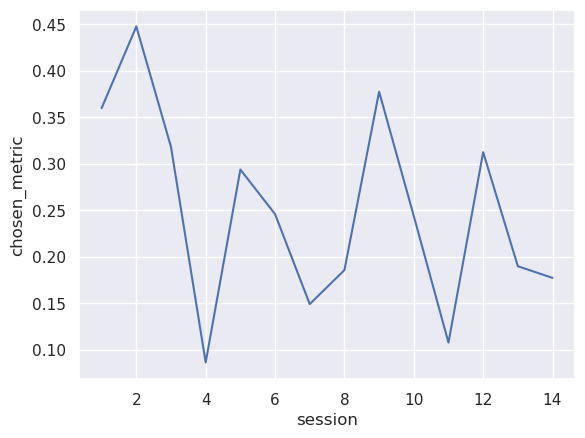

In [17]:
sns.lineplot(subject_summary_data, x='session', y='chosen_metric')

In [18]:
# Concatenate subjects 

summary_dfs = []

for subject_id, data in processed_results.items():
    # Get summary data for each subject
    df = data['summary_data']

    # Add subject_id column 
    df['subject_id'] = subject_id

    summary_dfs.append(df)

# Concat all DataFrames
combined_summary = pd.concat(summary_dfs, ignore_index=True)

# Convert to appropriate dtypes
combined_summary['subject_id'] = combined_summary['subject_id'].astype('int64')

combined_summary.dtypes # Take from trial data or combine with session level DataFrame? 

session_date        datetime64[ns]
chosen_metric              float64
auto_train_stage            object
session                      int64
subject_id                   int64
dtype: object

<Axes: xlabel='session', ylabel='chosen_metric'>

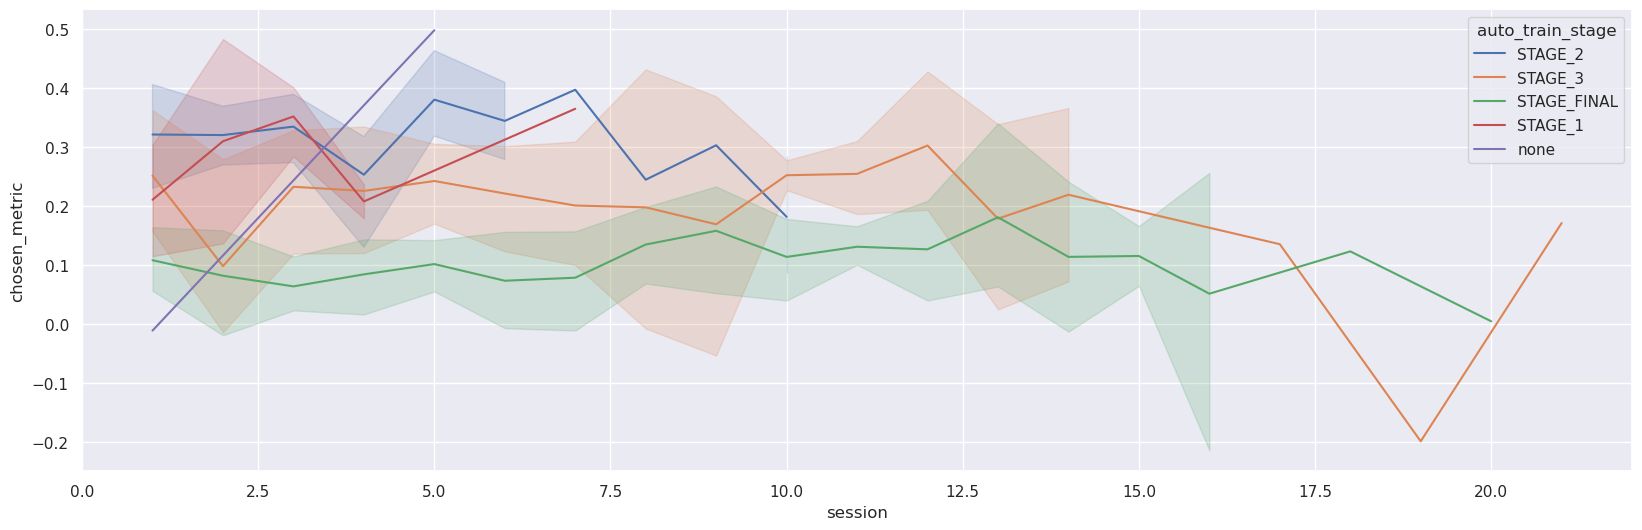

In [19]:
plt.figure(figsize=(20,6))
sns.lineplot(combined_summary, x='session', y='chosen_metric', hue='auto_train_stage')

In [20]:
subject = 711039

subject_combined = combined_summary[combined_summary['subject_id'] == subject]
subject_combined


,session_date,chosen_metric,auto_train_stage,session,subject_id
170,2024-08-07,0.359699,STAGE_2,1,711039
171,2024-08-08,0.447563,STAGE_2,2,711039
172,2024-08-09,0.317986,STAGE_2,3,711039
173,2024-08-12,0.086239,STAGE_3,4,711039
174,2024-08-14,0.293666,STAGE_3,5,711039
175,2024-08-15,0.245779,STAGE_3,6,711039
176,2024-08-16,0.149007,STAGE_3,7,711039
177,2024-08-19,0.185550,STAGE_3,8,711039
178,2024-08-20,0.377432,STAGE_3,9,711039
179,2024-08-28,0.243697,STAGE_FINAL,10,711039


<Axes: xlabel='session', ylabel='chosen_metric'>

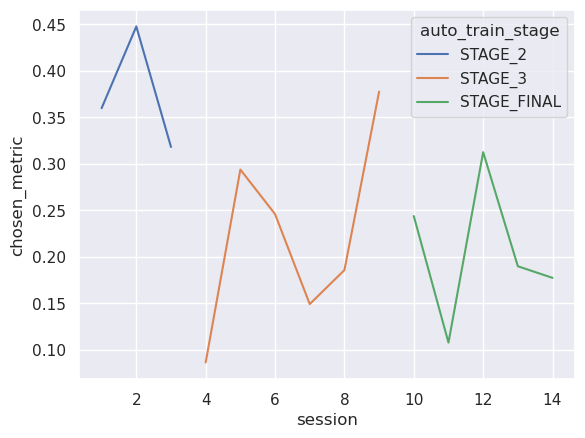

In [21]:
sns.lineplot(subject_combined, x='session', y='chosen_metric', hue='auto_train_stage')